## Multi-Label Genre Classification of Movies From Their Posters using Convolutional Neural Networks

> Indented




In [0]:
!pip install tensorflow-gpu==2.0.0-rc0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Authenticate and creating PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Getting file
data = drive.CreateFile({'id':"1vcD9htOfgCssy2Rl4d3SuozZjCHZH6kX"})
data.GetContentFile('movies_metadata.csv')

In [0]:
import pandas as pd


input_file = pd.read_csv('movies_metadata.csv')
num_rows = len(input_file.index)
# Creating a new dataframe with only the columns that we want
outdf = pd.DataFrame(index=range(num_rows), columns=['id', 'title', 'genres', 'posterpath'])
outdf['id'] = input_file['id']
outdf['title'] = input_file['title']
outdf['genres'] = input_file['genres']
outdf['posterpath'] = input_file['poster_path']
# outdf = outdf.set_index('id')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Get the indexes of rows with no genre or posterpath and delete them from the dataframe
nullGenres = outdf[outdf['genres'] == '[]'].index
outdf.drop(nullGenres, inplace=True)
nullPosters = outdf[outdf['posterpath'].isnull()].index
outdf.drop(nullPosters, inplace=True)
dropIds = ['106605','121351','140470','156415','1997-08-20','2012-09-29','2014-01-01','215908','23022','31772','35810','38585','53571','55602','56325','77621','79968']
outdf = outdf[~outdf['id'].isin(dropIds)]
outdf = outdf.drop_duplicates(subset='id')
outdf
# outdf.dtypes

,id,title,genres,posterpath
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",/rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",/e64sOI48hQXyru7naBFyssKFxVd.jpg
...,...,...,...,...
45459,222848,Caged Heat 3000,"[{'id': 878, 'name': 'Science Fiction'}]",/4lF9LH0b0Z1X94xGK9IOzqEW6k1.jpg
45460,30840,Robin Hood,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",/fQC46NglNiEMZBv5XHoyLuOWoN5.jpg
45461,439050,Subdue,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",/jldsYflnId4tTWPx8es3uzsB1I8.jpg
45462,111109,Century of Birthing,"[{'id': 18, 'name': 'Drama'}]",/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg


In [0]:
# Group movies by genre using binary classification

import json


In [0]:
# Method to create new dataframe with the an exact amount of movies (cannot exceed around 42000)
movie_count = 5000
selected_movies = outdf.sample(movie_count)
# selected_movies.columns
selected_movies = selected_movies.reset_index(drop=True)
selected_movies


# Below saves the dataframe as a csv file 
# selected_movies.to_csv('selected_movies_10k.csv')
# !cp selected_movies_10k.csv /content/drive/My\ Drive/Movie\ Poster\ ML/data/

,id,title,genres,posterpath
0,22554,The Subtenant,"[{'id': 35, 'name': 'Comedy'}]",/4YOyMHxLCBb3LlaAnCXQ4OJSc3W.jpg
1,238124,The Plainsman,"[{'id': 37, 'name': 'Western'}]",/3gNHqp1103tqQhRx9FzLrchzWqD.jpg
2,10467,The Road to Wellville,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",/3i5zFVewQMGlcPhsHoHmf0VHV02.jpg
3,291613,Mistrial,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",/b6wfSny76AGQCJZdiEz0Q8PJgEa.jpg
4,5176,3:10 to Yuma,"[{'id': 37, 'name': 'Western'}]",/9Nwkh0eQmkymEOR0ovAALtjSIZW.jpg
...,...,...,...,...
4995,38742,Cops,"[{'id': 35, 'name': 'Comedy'}]",/lfS4GZ900q5iX09WHsluOl1AlsC.jpg
4996,21900,Shifty,"[{'id': 53, 'name': 'Thriller'}]",/ijRyVleCeXCEKAnmHP4l58HLIym.jpg
4997,30636,La Luna,"[{'id': 18, 'name': 'Drama'}]",/sNtQ7FXrpV1qlmC0p4MfiqmJ4QP.jpg
4998,116167,56 Up,"[{'id': 99, 'name': 'Documentary'}]",/32tZc2nndes6xKDHR7sBibIEzZ7.jpg


In [0]:
# selected_movies.iloc[1, 2] # iloc[index, coulumn] gives the data in that cell

In [0]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


from sklearn.model_selection import train_test_split
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# Get all image layers for the set to use
# IMPORTANT: for this to work, you must right click on the shared Movie Poster ML
# folder in your drive and add it to your drive

img_width = 185
img_height = 185

X = []
# outdf['id'][1]
# print(selected_movies.iloc[1, 0])



for i in tqdm(range(selected_movies.shape[0])):
  path = '/content/drive/My Drive/Movie Poster ML/data/PosterImages/' + selected_movies.iloc[i, 0] + '.jpg'
  img = image.load_img(path, target_size=(img_width, img_height, 3))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)

X = np.array(X)






  0%|          | 0/5000 [00:00<?, ?it/s]




  0%|          | 1/5000 [00:00<18:55,  4.40it/s]




  0%|          | 2/5000 [00:00<19:49,  4.20it/s]




  0%|          | 3/5000 [00:00<20:44,  4.02it/s]




  0%|          | 4/5000 [00:01<29:40,  2.81it/s]




  0%|          | 5/5000 [00:01<27:43,  3.00it/s]




  0%|          | 6/5000 [00:02<32:14,  2.58it/s]




  0%|          | 7/5000 [00:02<28:55,  2.88it/s]




  0%|          | 8/5000 [00:02<26:07,  3.19it/s]




  0%|          | 9/5000 [00:03<27:41,  3.00it/s]




  0%|          | 10/5000 [00:03<25:55,  3.21it/s]




  0%|          | 11/5000 [00:03<24:40,  3.37it/s]




  0%|          | 12/5000 [00:03<24:39,  3.37it/s]




  0%|          | 13/5000 [00:04<23:55,  3.47it/s]




  0%|          | 14/5000 [00:04<22:54,  3.63it/s]




  0%|          | 15/5000 [00:04<20:47,  4.00it/s]




  0%|          | 16/5000 [00:04<22:56,  3.62it/s]




  0%|          | 17/5000 [00:05<21:12,  3.92it/s]




  0%|          | 18/5000 [00:05<20:51,  3

In [0]:
y = pd.read_csv('drive/My Drive/Movie Poster ML/data/movies_metadata_processed.csv')
y = y.drop_duplicates(subset = 'id')
Y = pd.DataFrame()
for i in tqdm(range(X.shape[0])):
  row = y.loc[y['id'] == int(selected_movies.iloc[i, 0])]
  Y = Y.append(row)
Y = Y.drop(['id', 'title', 'genres', 'posterpath'], axis = 1)
Y = Y.to_numpy()
print(Y.shape)
print(X.shape)






  0%|          | 0/5000 [00:00<?, ?it/s]




  1%|          | 51/5000 [00:00<00:09, 502.32it/s]




  2%|▏         | 101/5000 [00:00<00:09, 501.56it/s]




  3%|▎         | 151/5000 [00:00<00:09, 498.53it/s]




  4%|▍         | 200/5000 [00:00<00:09, 495.69it/s]




  5%|▍         | 249/5000 [00:00<00:09, 490.94it/s]




  6%|▌         | 297/5000 [00:00<00:09, 487.21it/s]




  7%|▋         | 345/5000 [00:00<00:09, 483.20it/s]




  8%|▊         | 390/5000 [00:00<00:09, 471.85it/s]




  9%|▊         | 436/5000 [00:00<00:09, 467.52it/s]




 10%|▉         | 483/5000 [00:01<00:09, 465.11it/s]




 11%|█         | 529/5000 [00:01<00:09, 462.83it/s]




 12%|█▏        | 575/5000 [00:01<00:09, 457.14it/s]




 12%|█▏        | 621/5000 [00:01<00:09, 457.74it/s]




 13%|█▎        | 667/5000 [00:01<00:09, 454.92it/s]




 14%|█▍        | 713/5000 [00:01<00:09, 454.55it/s]




 15%|█▌        | 759/5000 [00:01<00:09, 452.11it/s]




 16%|█▌        | 805/5000 [00:01<00:09, 445.27it/s]





(5000, 20)
(5000, 185, 185, 3)


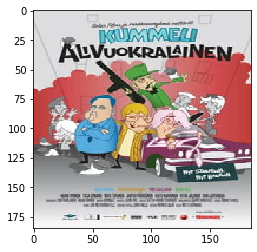

In [0]:
# Allows you to plot a poster
plt.imshow(X[0])

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.15)
X_train[0].shape

(185, 185, 3)

In [0]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


#model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))


model.add(Dense(20, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 183, 183, 16)      448       
_________________________________________________________________
batch_normalization_16 (Batc (None, 183, 183, 16)      64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 91, 91, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 91, 91, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 89, 89, 32)        4640      
_________________________________________________________________
batch_normalization_17 (Batc (None, 89, 89, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 44, 44, 32)       

In [0]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [0]:
num_epochs = 5
history = model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_test, Y_test))

Train on 4250 samples, validate on 750 samples
Epoch 1/5
4250/4250 [==============================] - 36s 8ms/sample - loss: 0.4003 - accuracy: 0.8930 - val_loss: 0.5855 - val_accuracy: 0.8739
Epoch 2/5
4250/4250 [==============================] - 35s 8ms/sample - loss: 0.3446 - accuracy: 0.8952 - val_loss: 0.6149 - val_accuracy: 0.8909
Epoch 3/5
4250/4250 [==============================] - 35s 8ms/sample - loss: 0.3259 - accuracy: 0.8953 - val_loss: 0.5343 - val_accuracy: 0.8907
Epoch 4/5
4250/4250 [==============================] - 35s 8ms/sample - loss: 0.3179 - accuracy: 0.8952 - val_loss: 0.5447 - val_accuracy: 0.8905
Epoch 5/5
4250/4250 [==============================] - 35s 8ms/sample - loss: 0.3106 - accuracy: 0.8952 - val_loss: 0.6155 - val_accuracy: 0.8885


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend

In [0]:


# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score
 

In [0]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(X_train, Y_train, batch_size=128)
	test_it = datagen.flow(X_test, Y_test, batch_size=128)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
 

In [0]:
run_test_harness()

NameError: ignored

In [0]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()


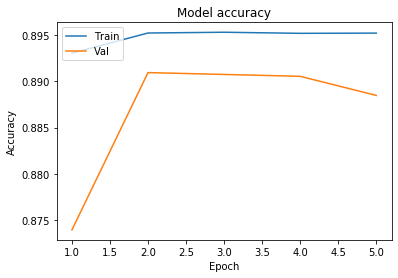

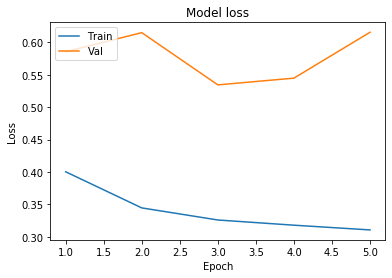

In [0]:
# Change epoch number to max of what we train on
plot_learningCurve(history, num_epochs)

In [0]:
#Testing Model

img = image.load_img('INPUT IMAGE HERE', target_size=(img_width, img_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0

img = img.reshape(1, img_width, img_height, 3)

classes = data.columns[2:]
print(classes)
y_prob = model.predict(img)
top3 = np.argsort(y_prob[0])[:-4:-1]

for i in range(3):
  print(classes[top3[i]])

In [0]:
#Print out probabilities 
y_prob[0]